# 🔧 Feature Engineering
## Creación de Variables para Mejorar el Modelo de Churn

**En este notebook vamos a:**
1. Crear nuevas variables a partir de las existentes
2. Hacer transformaciones de variables numéricas
3. Encodear variables categóricas
4. Crear variables de interacción
5. Preparar el dataset final para modelado

---

In [4]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print('✅ Librerías cargadas')

✅ Librerías cargadas


## 1️⃣ Cargar y Preparar Datos

In [5]:
# Cargar datos
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f'Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas')
df.head()

Dataset cargado: 7043 filas, 21 columnas


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Limpieza básica (como en notebooks anteriores)
# Convertir TotalCharges a numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Eliminar filas con valores nulos en TotalCharges
df = df.dropna(subset=['TotalCharges'])

# Convertir Churn a binario (0/1)
df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)

print(f'✅ Dataset limpio: {df.shape[0]} filas')
print(f'Tasa de churn: {df.Churn_Binary.mean():.2%}')

✅ Dataset limpio: 7032 filas
Tasa de churn: 26.58%


## 2️⃣ Feature Engineering - Variables Numéricas

Vamos a crear nuevas variables derivadas de las numéricas existentes.

In [7]:
# Crear una copia para trabajar
df_fe = df.copy()

# 1. Gasto mensual promedio (TotalCharges / tenure)
# Evitar división por 0
df_fe['AvgMonthlyCharges'] = df_fe.apply(
    lambda row: row['TotalCharges'] / row['tenure'] if row['tenure'] > 0 else row['MonthlyCharges'],
    axis=1
)

# 2. Proporción de gasto total vs esperado
# Si alguien lleva 12 meses y paga $50/mes, debería tener ~$600 acumulado
df_fe['ChargeRatio'] = df_fe.apply(
    lambda row: row['TotalCharges'] / (row['MonthlyCharges'] * row['tenure']) if row['tenure'] > 0 else 1,
    axis=1
)

# 3. Categorizar tenure en grupos
df_fe['TenureGroup'] = pd.cut(df_fe['tenure'], 
                               bins=[0, 12, 24, 48, 72],
                               labels=['0-1 año', '1-2 años', '2-4 años', '4-6 años'])

# 4. Categorizar MonthlyCharges
df_fe['MonthlyChargesGroup'] = pd.cut(df_fe['MonthlyCharges'],
                                       bins=[0, 35, 70, 100, 150],
                                       labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])

print('✅ Variables numéricas creadas:')
print('  - AvgMonthlyCharges: Gasto mensual promedio')
print('  - ChargeRatio: Proporción de gasto real vs esperado')
print('  - TenureGroup: Categorización de antigüedad')
print('  - MonthlyChargesGroup: Categorización de gasto mensual')

✅ Variables numéricas creadas:
  - AvgMonthlyCharges: Gasto mensual promedio
  - ChargeRatio: Proporción de gasto real vs esperado
  - TenureGroup: Categorización de antigüedad
  - MonthlyChargesGroup: Categorización de gasto mensual


In [8]:
# Verificar las nuevas variables
df_fe[['tenure', 'MonthlyCharges', 'TotalCharges', 
       'AvgMonthlyCharges', 'ChargeRatio', 'TenureGroup', 'MonthlyChargesGroup']].head(10)

,tenure,MonthlyCharges,TotalCharges,AvgMonthlyCharges,ChargeRatio,TenureGroup,MonthlyChargesGroup
0,1,29.85,29.85,29.850000,1.000000,0-1 año,Bajo
1,34,56.95,1889.50,55.573529,0.975830,2-4 años,Medio
2,2,53.85,108.15,54.075000,1.004178,0-1 año,Medio
3,45,42.30,1840.75,40.905556,0.967034,2-4 años,Medio
4,2,70.70,151.65,75.825000,1.072489,0-1 año,Alto
5,8,99.65,820.50,102.562500,1.029227,0-1 año,Alto
6,22,89.10,1949.40,88.609091,0.994490,1-2 años,Alto
7,10,29.75,301.90,30.190000,1.014790,0-1 año,Bajo
8,28,104.80,3046.05,108.787500,1.038049,2-4 años,Muy Alto
9,62,56.15,3487.95,56.257258,1.001910,4-6 años,Medio


## 3️⃣ Feature Engineering - Conteo de Servicios

Crear variables que cuenten cuántos servicios tiene cada cliente.

In [9]:
# Listar columnas de servicios
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Contar servicios activos
# Un servicio está activo si NO es 'No' y NO es 'No phone service' / 'No internet service'
df_fe['TotalServices'] = 0

for col in service_cols:
    if col in df_fe.columns:
        df_fe['TotalServices'] += (~df_fe[col].isin(['No', 'No phone service', 'No internet service'])).astype(int)

print(f'✅ Variable TotalServices creada')
print(f'Rango de servicios: {df_fe.TotalServices.min()} - {df_fe.TotalServices.max()}')
print(f'\nDistribución:\n{df_fe.TotalServices.value_counts().sort_index()}')

✅ Variable TotalServices creada
Rango de servicios: 1 - 9

Distribución:
TotalServices
1    1260
2     857
3     846
4     965
5     921
6     906
7     674
8     395
9     208
Name: count, dtype: int64


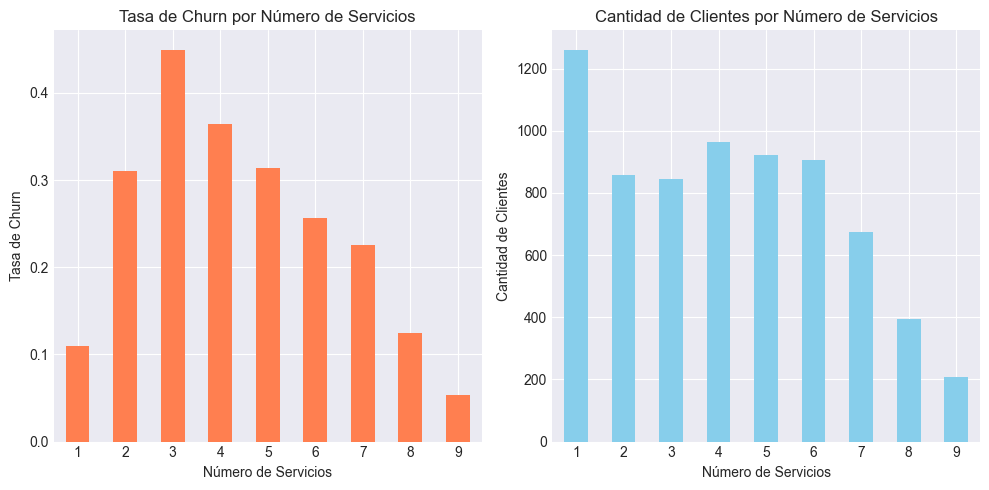

In [10]:
# Visualizar relación entre número de servicios y churn
plt.figure(figsize=(10, 5))

churn_by_services = df_fe.groupby('TotalServices')['Churn_Binary'].agg(['mean', 'count'])

plt.subplot(1, 2, 1)
churn_by_services['mean'].plot(kind='bar', color='coral')
plt.title('Tasa de Churn por Número de Servicios')
plt.xlabel('Número de Servicios')
plt.ylabel('Tasa de Churn')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
churn_by_services['count'].plot(kind='bar', color='skyblue')
plt.title('Cantidad de Clientes por Número de Servicios')
plt.xlabel('Número de Servicios')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## 4️⃣ Feature Engineering - Variables de Servicios Premium/Protección

Agrupar servicios relacionados.

In [11]:
# Servicios de protección (seguridad, backup, device protection, tech support)
protection_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

df_fe['HasProtectionServices'] = 0
for col in protection_cols:
    if col in df_fe.columns:
        df_fe['HasProtectionServices'] += (df_fe[col] == 'Yes').astype(int)

df_fe['HasAnyProtection'] = (df_fe['HasProtectionServices'] > 0).astype(int)

# Servicios de streaming
streaming_cols = ['StreamingTV', 'StreamingMovies']

df_fe['HasStreamingServices'] = 0
for col in streaming_cols:
    if col in df_fe.columns:
        df_fe['HasStreamingServices'] += (df_fe[col] == 'Yes').astype(int)

df_fe['HasAnyStreaming'] = (df_fe['HasStreamingServices'] > 0).astype(int)

print('✅ Variables de servicios agrupados creadas:')
print('  - HasProtectionServices: Número de servicios de protección (0-4)')
print('  - HasAnyProtection: Si tiene al menos un servicio de protección')
print('  - HasStreamingServices: Número de servicios de streaming (0-2)')
print('  - HasAnyStreaming: Si tiene al menos un servicio de streaming')

✅ Variables de servicios agrupados creadas:
  - HasProtectionServices: Número de servicios de protección (0-4)
  - HasAnyProtection: Si tiene al menos un servicio de protección
  - HasStreamingServices: Número de servicios de streaming (0-2)
  - HasAnyStreaming: Si tiene al menos un servicio de streaming


## 5️⃣ Feature Engineering - Variables de Contrato/Pago

Combinar información de contrato y método de pago.

In [12]:
# 1. Cliente con contrato largo Y pago automático (muy bajo riesgo)
df_fe['LongTermAutoPayment'] = (
    (df_fe['Contract'].isin(['One year', 'Two year'])) & 
    (df_fe['PaymentMethod'].isin(['Bank transfer (automatic)', 'Credit card (automatic)']))
).astype(int)

# 2. Cliente riesgoso (mes a mes + pago manual)
df_fe['HighRiskCustomer'] = (
    (df_fe['Contract'] == 'Month-to-month') & 
    (df_fe['PaymentMethod'].isin(['Electronic check', 'Mailed check']))
).astype(int)

# 3. Tiene facturación electrónica
df_fe['HasPaperlessBilling'] = (df_fe['PaperlessBilling'] == 'Yes').astype(int)

print('✅ Variables de contrato/pago creadas:')
print(f'  - LongTermAutoPayment: {df_fe.LongTermAutoPayment.sum()} clientes ({df_fe.LongTermAutoPayment.mean():.1%})')
print(f'  - HighRiskCustomer: {df_fe.HighRiskCustomer.sum()} clientes ({df_fe.HighRiskCustomer.mean():.1%})')
print(f'  - HasPaperlessBilling: {df_fe.HasPaperlessBilling.sum()} clientes ({df_fe.HasPaperlessBilling.mean():.1%})')

✅ Variables de contrato/pago creadas:
  - LongTermAutoPayment: 1931 clientes (27.5%)
  - HighRiskCustomer: 2743 clientes (39.0%)
  - HasPaperlessBilling: 4168 clientes (59.3%)


In [13]:
# Verificar efectividad de estas variables
print('📊 Tasa de Churn por Tipo de Cliente:\n')
print(f'LongTermAutoPayment = 1: {df_fe[df_fe.LongTermAutoPayment==1].Churn_Binary.mean():.2%}')
print(f'LongTermAutoPayment = 0: {df_fe[df_fe.LongTermAutoPayment==0].Churn_Binary.mean():.2%}')
print()
print(f'HighRiskCustomer = 1: {df_fe[df_fe.HighRiskCustomer==1].Churn_Binary.mean():.2%}')
print(f'HighRiskCustomer = 0: {df_fe[df_fe.HighRiskCustomer==0].Churn_Binary.mean():.2%}')

📊 Tasa de Churn por Tipo de Cliente:

LongTermAutoPayment = 1: 5.75%
LongTermAutoPayment = 0: 34.46%

HighRiskCustomer = 1: 46.52%
HighRiskCustomer = 0: 13.83%


## 6️⃣ Encoding de Variables Categóricas

Convertir variables categóricas a formato numérico para los modelos.

In [14]:
# Crear una copia para encoding
df_encoded = df_fe.copy()

# Variables binarias simples (Yes/No) -> 1/0
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in binary_cols:
    if col in df_encoded.columns:
        df_encoded[col + '_encoded'] = (df_encoded[col] == 'Yes').astype(int)

print('✅ Variables binarias encodeadas')

# Gender -> 1/0
df_encoded['Gender_encoded'] = (df_encoded['gender'] == 'Male').astype(int)

print('✅ Gender encodeado')

✅ Variables binarias encodeadas
✅ Gender encodeado


In [15]:
# Variables con más de 2 categorías -> One-Hot Encoding
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaymentMethod']

# One-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

print(f'✅ One-hot encoding aplicado')
print(f'Dataset ahora tiene {df_encoded.shape[1]} columnas')

✅ One-hot encoding aplicado
Dataset ahora tiene 50 columnas


## 7️⃣ Resumen de Features Creadas

In [16]:
# Listar todas las nuevas features
new_features = [
    'AvgMonthlyCharges',
    'ChargeRatio',
    'TotalServices',
    'HasProtectionServices',
    'HasAnyProtection',
    'HasStreamingServices',
    'HasAnyStreaming',
    'LongTermAutoPayment',
    'HighRiskCustomer',
    'HasPaperlessBilling'
]

print('📋 RESUMEN DE FEATURES CREADAS:\n')
print('=' * 60)

for i, feature in enumerate(new_features, 1):
    if feature in df_encoded.columns:
        print(f'{i}. {feature}')
        if df_encoded[feature].dtype in ['float64', 'int64']:
            print(f'   Tipo: Numérica')
            print(f'   Min: {df_encoded[feature].min():.2f}, Max: {df_encoded[feature].max():.2f}, Media: {df_encoded[feature].mean():.2f}')
        print()

print('=' * 60)
print(f'\n✅ Total de features nuevas: {len(new_features)}')
print(f'✅ Total de columnas en dataset final: {df_encoded.shape[1]}')

📋 RESUMEN DE FEATURES CREADAS:

1. AvgMonthlyCharges
   Tipo: Numérica
   Min: 13.78, Max: 121.40, Media: 64.80

2. ChargeRatio
   Tipo: Numérica
   Min: 0.69, Max: 1.57, Media: 1.00

3. TotalServices
   Tipo: Numérica
   Min: 1.00, Max: 9.00, Media: 4.15

4. HasProtectionServices
   Tipo: Numérica
   Min: 0.00, Max: 4.00, Media: 1.27

5. HasAnyProtection

6. HasStreamingServices
   Tipo: Numérica
   Min: 0.00, Max: 2.00, Media: 0.77

7. HasAnyStreaming

8. LongTermAutoPayment

9. HighRiskCustomer

10. HasPaperlessBilling


✅ Total de features nuevas: 10
✅ Total de columnas en dataset final: 50


## 8️⃣ Preparar Dataset Final para Modelado

In [17]:
# Seleccionar features para el modelo
# Eliminar columnas que no necesitamos
cols_to_drop = ['customerID', 'Churn', 'gender', 'TenureGroup', 'MonthlyChargesGroup']

# Eliminar columnas originales que ya fueron encodeadas
for col in binary_cols:
    if col in df_encoded.columns:
        cols_to_drop.append(col)

df_model = df_encoded.drop(columns=[col for col in cols_to_drop if col in df_encoded.columns])

print(f'✅ Dataset para modelado: {df_model.shape[0]} filas, {df_model.shape[1]} columnas')
print(f'\nColumnas incluidas:')
print(df_model.columns.tolist())

✅ Dataset para modelado: 7032 filas, 41 columnas

Columnas incluidas:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Binary', 'AvgMonthlyCharges', 'ChargeRatio', 'TotalServices', 'HasProtectionServices', 'HasAnyProtection', 'HasStreamingServices', 'HasAnyStreaming', 'LongTermAutoPayment', 'HighRiskCustomer', 'HasPaperlessBilling', 'Partner_encoded', 'Dependents_encoded', 'PhoneService_encoded', 'PaperlessBilling_encoded', 'Gender_encoded', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automa

In [18]:
# Separar features (X) y target (y)
X = df_model.drop('Churn_Binary', axis=1)
y = df_model['Churn_Binary']

print(f'✅ Features (X): {X.shape}')
print(f'✅ Target (y): {y.shape}')
print(f'\nDistribución del target:')
print(y.value_counts())
print(f'\nTasa de churn: {y.mean():.2%}')

✅ Features (X): (7032, 40)
✅ Target (y): (7032,)

Distribución del target:
Churn_Binary
0    5163
1    1869
Name: count, dtype: int64

Tasa de churn: 26.58%


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Mantener la proporción de churn en train y test
)

print('✅ Train-Test Split completado')
print(f'\nTrain set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'\nTasa de churn en train: {y_train.mean():.2%}')
print(f'Tasa de churn en test: {y_test.mean():.2%}')

✅ Train-Test Split completado

Train set: 5625 samples
Test set: 1407 samples

Tasa de churn en train: 26.58%
Tasa de churn en test: 26.58%


## 9️⃣ Normalización de Variables Numéricas

In [20]:
# Identificar columnas numéricas que necesitan scaling
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 
                'AvgMonthlyCharges', 'ChargeRatio']

# Crear scaler
scaler = StandardScaler()

# Fit en train, transform en train y test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print('✅ Normalización aplicada')
print(f'\nEjemplo de valores normalizados (train):')
print(X_train_scaled[numeric_cols].head())

✅ Normalización aplicada

Ejemplo de valores normalizados (train):
        tenure  MonthlyCharges  TotalCharges  AvgMonthlyCharges  ChargeRatio
1413  1.321816        0.981556      1.659900           0.943761    -0.216400
7003 -0.267410       -0.971546     -0.562252          -0.849298     2.002729
3355  1.444064        0.837066      1.756104           0.913760     0.536564
4494 -1.204646        0.641092     -0.908326           0.441857    -1.409997
3541  0.669826       -0.808787     -0.101561          -0.752245     0.793872


## 🔟 Guardar Datasets Procesados

In [21]:
# Crear carpetas si no existen
import os
os.makedirs('data/processed', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Guardar datasets en data/processed/
X_train_scaled.to_csv('data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('data/processed/y_train.csv', index=False)
y_test.to_csv('data/processed/y_test.csv', index=False)

# También guardar versiones sin escalar por si acaso
X_train.to_csv('data/processed/X_train.csv', index=False)
X_test.to_csv('data/processed/X_test.csv', index=False)

# Guardar el scaler en carpeta models/ para uso futuro
import joblib
joblib.dump(scaler, 'models/scaler.pkl')

print('✅ Datasets guardados en data/processed/:')
print('  - data/processed/X_train_scaled.csv')
print('  - data/processed/X_test_scaled.csv')
print('  - data/processed/X_train.csv')
print('  - data/processed/X_test.csv')
print('  - data/processed/y_train.csv')
print('  - data/processed/y_test.csv')
print('\n✅ Scaler guardado en models/:')
print('  - models/scaler.pkl')

✅ Datasets guardados en data/processed/:
  - data/processed/X_train_scaled.csv
  - data/processed/X_test_scaled.csv
  - data/processed/X_train.csv
  - data/processed/X_test.csv
  - data/processed/y_train.csv
  - data/processed/y_test.csv

✅ Scaler guardado en models/:
  - models/scaler.pkl


## 📊 Resumen Final

In [22]:
print('=' * 70)
print('🎯 FEATURE ENGINEERING - RESUMEN FINAL')
print('=' * 70)
print()
print('📈 FEATURES CREADAS:')
print('  1. AvgMonthlyCharges: Gasto mensual promedio histórico')
print('  2. ChargeRatio: Ratio de gasto real vs esperado')
print('  3. TotalServices: Cantidad total de servicios contratados')
print('  4. HasProtectionServices: Número de servicios de protección')
print('  5. HasAnyProtection: Flag de protección (0/1)')
print('  6. HasStreamingServices: Número de servicios de streaming')
print('  7. HasAnyStreaming: Flag de streaming (0/1)')
print('  8. LongTermAutoPayment: Cliente de bajo riesgo (0/1)')
print('  9. HighRiskCustomer: Cliente de alto riesgo (0/1)')
print(' 10. HasPaperlessBilling: Facturación electrónica (0/1)')
print()
print('🔧 TRANSFORMACIONES:')
print('  ✓ Variables binarias encodeadas (Yes/No -> 1/0)')
print('  ✓ Variables categóricas con One-Hot Encoding')
print('  ✓ Variables numéricas normalizadas (StandardScaler)')
print()
print('📦 DATASETS GENERADOS:')
print(f'  Train: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features')
print(f'  Test:  {X_test_scaled.shape[0]} samples, {X_test_scaled.shape[1]} features')
print()
print('✅ Dataset listo para modelado!')
print('=' * 70)

🎯 FEATURE ENGINEERING - RESUMEN FINAL

📈 FEATURES CREADAS:
  1. AvgMonthlyCharges: Gasto mensual promedio histórico
  2. ChargeRatio: Ratio de gasto real vs esperado
  3. TotalServices: Cantidad total de servicios contratados
  4. HasProtectionServices: Número de servicios de protección
  5. HasAnyProtection: Flag de protección (0/1)
  6. HasStreamingServices: Número de servicios de streaming
  7. HasAnyStreaming: Flag de streaming (0/1)
  8. LongTermAutoPayment: Cliente de bajo riesgo (0/1)
  9. HighRiskCustomer: Cliente de alto riesgo (0/1)
 10. HasPaperlessBilling: Facturación electrónica (0/1)

🔧 TRANSFORMACIONES:
  ✓ Variables binarias encodeadas (Yes/No -> 1/0)
  ✓ Variables categóricas con One-Hot Encoding
  ✓ Variables numéricas normalizadas (StandardScaler)

📦 DATASETS GENERADOS:
  Train: 5625 samples, 40 features
  Test:  1407 samples, 40 features

✅ Dataset listo para modelado!


---

## 🚀 Próximos Pasos

En el siguiente notebook empezaremos con **Modelado**:
1. Baseline model (Logistic Regression)
2. Random Forest
3. XGBoost
4. Comparación de modelos
5. Feature importance

**¡Guarda este notebook y haz commit!**